<a href="https://colab.research.google.com/github/marionboynton/Reinforcement-Learning-/blob/main/RL_Tabular_Methods.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Solving Grid World with various Tabular Methods

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random

In [23]:
class GridWorld(object):
    def __init__(self, p):
        
        ### Attributes defining the Gridworld #######
        # Shape of the gridworld
        self.shape = (6,6)
        
        # Locations of the obstacles
        self.obstacle_locs = [(1,1),(3,1),(4, 1), (4,2),(2,3),(2,5),(4,4)]
        
        # Locations for the absorbing states
        self.absorbing_locs = [(4,3),(1,2)]
        
        # Rewards for each of the absorbing states 
        self.special_rewards = [-100, 10] #corresponds to each of the absorbing_locs
        
        # Reward for all the other states
        self.default_reward = -1
        
        #states in order
        self.states_order = [12,13,14,15,16,17,1,2,3,4,19,20,5,6,7,21,8,9,10,22,23,11,24,25,26,27,28,29,30]

        # Action names
        self.action_names = ['N','E','S','W']
        
        # Number of actions
        self.action_size = len(self.action_names)
        
        
        # Randomizing action results: [1 0 0 0] to no Noise in the action results.
        #self.action_randomizing_array = [0.45, 11/60, 11/60 , 11/60]
        po = (1-p)/3
        self.action_randomizing_array = [p, po, po , po]
        #self.action_randomizing_array = [1, 0, 0 , 0]
        ###########################################
    
        #### Internal State  ####
        
        # Get attributes defining the world
        state_size, T, R, absorbing, locs = self.build_grid_world()
        
        # Number of valid states in the gridworld (there are 22 of them)
        self.state_size = state_size
        
        # Transition operator (3D tensor)
        self.T = T
        
        # Reward function (3D tensor)
        self.R = R
        
        # Absorbing states
        self.absorbing = absorbing
        
        # The locations of the valid states
        self.locs = locs

        self.non_absorbing = [x for x in self.locs if x not in self.absorbing_locs]
        
        # Starting location
        self.starting_loc = random.choice(self.non_absorbing)

        # Number of the starting state
        self.starting_state = self.loc_to_state_idx(self.starting_loc, locs);
        
        # Locating the initial state
        self.initial = np.zeros((1,len(locs)))
        self.initial[0,self.starting_state] = 1
        
        
        # Placing the walls on a bitmap
        self.walls = np.zeros(self.shape);
        for ob in self.obstacle_locs:
            self.walls[ob]=1
            
        # Placing the absorbers on a grid for illustration
        self.absorbers = np.zeros(self.shape)
        for ab in self.absorbing_locs:
            self.absorbers[ab] = -1
        
        # Placing the rewarders on a grid for illustration
        self.rewarders = np.zeros(self.shape)
        for i, rew in enumerate(self.absorbing_locs):
            self.rewarders[rew] = self.special_rewards[i]
        
        #Illustrating the grid world
        self.paint_maps()
        ################################

    ####### Getters ###########
    def get_transition_matrix(self):
        return self.T
    
    def get_reward_matrix(self):
        return self.R
    
    ########################
    

    ####### Q Learning Methods #########
    def policy_evaluation(self, threshold, discount, policy):
    
        # Make sure delta is bigger than the threshold to start with
        delta= 2*threshold
        
        #Get the reward and transition matrices
        R = self.get_reward_matrix()
        T = self.get_transition_matrix()
        
        # The value is initialised at 0
        V = np.zeros(policy.shape[0])
        # Make a deep copy of the value array to hold the update during the evaluation
        Vnew = np.copy(V)
        V_list = np.array([Vnew])

        epochs=0
        # While the Value has not yet converged do:
        while delta>=threshold:
            epochs +=1
            for state_idx in range(policy.shape[0]):
                # If it is one of the absorbing states, ignore
                if(self.absorbing[0,state_idx]):
                    continue   
                
                # Accumulator variable for the Value of a state
                tmpV = 0
                for action_idx in range(policy.shape[1]):
                    # Accumulator variable for the State-Action Value
                    tmpQ = 0
                    for state_idx_prime in range(policy.shape[0]):
                        tmpQ = tmpQ + T[state_idx_prime,state_idx,action_idx] * (R[state_idx_prime,state_idx, action_idx] + discount * V[state_idx_prime])
                    
                    tmpV += policy[state_idx,action_idx] * tmpQ
                    
                # Update the value of the state
                Vnew[state_idx] = tmpV
            
            # After updating the values of all states, update the delta
            delta =  max(abs(Vnew-V))
            # and save the new value into the old
            V=np.copy(Vnew)
            V_list = np.append(V_list, [V], axis=0)
        return V, V_list, epochs
    

    def policy_iteration(self, threshold, discount, policy_evaluation=policy_evaluation):
        #Get the reward and transition matrices
        R = self.get_reward_matrix()
        T = self.get_transition_matrix()

        policy = np.ones((self.state_size, self.action_size))*0.25 # Vector of 0
        #policy[:,0] = 1 # Initialise policy to choose action 1 systematically
        epochs = 0
        policy_stable = False

        #iterations = 0
        while not policy_stable: 
          #policy evaluation
          V, V_list, epochs_eval = policy_evaluation(self, threshold=threshold, discount=discount, policy=policy)
          epochs += epochs_eval
          
          #policy improvement
          s_policy_stable = (self.absorbing ==1)[0]
        
          # Make a deep copy of the value array to hold the update during the evaluation
          #Vnew = np.copy(V)
  
          for state_idx in range(policy.shape[0]):
                # If it is one of the absorbing states, ignore
                if(self.absorbing[0,state_idx]):
                    continue 
                
                current_action = np.argmax(policy[state_idx,:])
                #policy_imp[state_idx].copy()
                #action_idx_max=np.argmax(policy_imp[state_idx])
                #Qmax= V[state_idx]
                
                # Compute Q value
                Q = np.zeros(4) # Initialise with value 0
                for state_idx_prime in range(policy.shape[0]):
                  Q += T[state_idx_prime,state_idx,:] * (R[state_idx_prime,state_idx, :] + discount * V[state_idx_prime])

                 # Compute corresponding policy
                  policy_imp = np.zeros(4)
                  policy_imp[np.argmax(Q)] = 1  # The action that maximises the Q value gets probability 1
                  policy[state_idx] = policy_imp
                
                  # Check if the policy has converged
                  if current_action == np.argmax(policy[state_idx]):
                    #policy_stable = True
                    s_policy_stable[state_idx] = True
          
          if np.all(s_policy_stable):
            policy_stable = True
        print('Epochs: ', epochs)
        #print('Optimatal State Values: ')    
        #print(V)    
        return policy, V

    def value_iteration(self, threshold, discount):
        # Make sure delta is bigger than the threshold to start with
        delta= threshold
        
        #Get the reward and transition matrices
        R = self.get_reward_matrix()
        T = self.get_transition_matrix() 
        state_size = self.state_size
        action_size = self.action_size

        # The value is initialised at 0
        V = np.zeros(state_size)
        # Make a deep copy of the value array to hold the update during the evaluation
        Vnew = np.copy(V)
        #V_list = np.array([Vnew])
        epochs =0

        # While the Value has not yet converged do:
        while delta>=threshold:
            epochs+=1 
            delta = 0 #reinitialize

            for state_idx in range(state_size):
                # If it is one of the absorbing states, ignore
                if not(self.absorbing[0,state_idx]):
                    #continue   
                
                # Accumulator variable for the Value of a state
                #tmpV = 0
                  Vc = V[state_idx]
                  Q = np.zeros(4) #state action values

                #for action_idx in range(action_size):
                    # Accumulator variable for the State-Action Value
                    #tmpQ = 0
                  for state_idx_prime in range(state_size):
                    #tmpQ = tmpQ + T[state_idx_prime,state_idx,action_idx] * (R[state_idx_prime,state_idx, action_idx] + discount * V[state_idx_prime])
                    Q += T[state_idx_prime,state_idx,:] * (R[state_idx_prime,state_idx, :] + discount * V[state_idx_prime])

                # Update the value of the state
                  V[state_idx] = np.max(Q)      #tmpV
                  delta =  max(delta, np.abs(Vc-V[state_idx]))
            #V_list = np.append(V_list, [V], axis=0)
        
        #print('Iterations: ', iterations)
        #print('Optimatal State Values: ')
        #print(V)

        policy_optimal = np.zeros((state_size, action_size))

        for state_idx in range(state_size):
                # If it is one of the absorbing states, ignore
                if(self.absorbing[0,state_idx]):
                    continue  

                #action_idx_max=0 
                #Qmax=0
                Q = np.zeros(4)
                for state_idx_prime in range(state_size):
                  Q += T[state_idx_prime,state_idx,:] * (R[state_idx_prime,state_idx, :] + discount * V[state_idx_prime])
                
                action_max = np.argmax(Q)
                policy_optimal[state_idx, action_max] = 1
        print('Epochs: ', epochs)
        return policy_optimal, V

    def draw_deterministic_policy(self, policy, title):
        # Draw a deterministic policy
        # The policy needs to be a np array of 22 values between 0 and 3 with
        # 0 -> N, 1->E, 2->S, 3->W
        action_policy = np.apply_along_axis((lambda x: np.argmax(x)), 1, policy)

        plt.figure()
        plt.imshow(self.walls+self.rewarders +self.absorbers)
        #plt.hold('on')
        for state, action in enumerate(action_policy):
            if(self.absorbing[0,state]):
                continue
            arrows = [r"$\uparrow$",r"$\rightarrow$", r"$\downarrow$", r"$\leftarrow$"]
            action_arrow = arrows[action]
            location = self.locs[state]
            plt.text(location[1], location[0], action_arrow, ha='center', va='center')
        plt.title(title)
        plt.show()


    def draw_value(self, Value, title):
        # Draw a policy value function
        # The value need to be a np array of 22 values 
        plt.figure()
        
        plt.imshow(self.walls+self.rewarders +self.absorbers) # Create the graph of the grid
        for state, value in enumerate(Value):
            if(self.absorbing[0,state]): # If it is an absorbing state, don't plot any value
                continue
            location = self.locs[state] # Compute the value location on graph
            plt.text(location[1], location[0], round(value,2), ha='center', va='center') # Place it on graph
        plt.title(title)
        plt.show()

#########


    def mdp_episode(self, policy, gamma=0.2):
        #action_policy = np.apply_along_axis((lambda x: np.argmax(x)), 1, policy)
        #action_policy = np.apply_along_axis((lambda x: np.argsort(-x)), 1, policy)
        #direction_policy. = 
        R = self.get_reward_matrix()
        T = self.get_transition_matrix() 
        locs = self.locs 
        state_size = self.state_size
        action_size = self.action_size
        actions = self.action_names
        directions = ['nr', 'ea', 'so', 'we']
        trace = np.empty((0,3))
        
        # Starting location
        loc = random.choice(self.non_absorbing)
        #state = self.starting_state
        
        while loc not in self.absorbing_locs:
          #pol_idx = 0
          state = self.loc_to_state_idx(loc, locs)
          state_label = self.loc_to_state_name(loc, locs)
          #print(state_label)
          
          #dir = action_policy[state]  #, pol_idx
          dir = np.random.choice([0,1,2,3] ,p=policy[state, :])
          next_loc_intended = self.get_neighbour(loc, directions[dir])

          next_state_intended = self.loc_to_state_idx(next_loc_intended, locs)
          trans = T[next_state_intended, state, :]
          action = np.random.choice([0,1,2,3] ,p=trans)
          next_loc = self.get_neighbour(loc, directions[action])
          next_state = self.loc_to_state_idx(next_loc, locs)
          #next_state_label = self.loc_to_state_name(next_loc, locs)
          reward = R[next_state, state, action]
          trace = np.append(trace, np.array([[int(state), int(action), reward]]), axis=0)

          loc = next_loc
        rewards = trace[:, 2]
        discounts = np.array([gamma**i for i in range(len(rewards))])
        #final_G = sum(rewards)
        final_G = sum(discounts*np.flip(rewards)) #total discounted return from last state looking backwards 
       
        return trace, final_G

    def td_estimation(self, policy, dpV, n, gamma=0.2):
        T = self.get_transition_matrix()
        R = self.get_reward_matrix()
        state_size = self.state_size
        action_size = self.action_size
        locs = self.locs 
        actions = self.action_names
        directions = ['nr', 'ea', 'so', 'we']

        alpha_start = 1
        alpha_decay = 0.99955
        alpha_min = 0.001

        V = np.zeros(self.state_size) # Initialise values at 0 for each state
        rmse = []
        final_ret = []
        episode_rewards = []

        alpha = alpha_start
        for i in range(n):
          if i%20000==0: print('ep:', i)
          alpha = max(alpha*alpha_decay, alpha_min)
          ep_reward = 0
          errors = []
          r_list = []
          
          # Starting location
          loc = random.choice(self.non_absorbing)
          state = self.loc_to_state_idx(loc, locs)

          while loc not in self.absorbing_locs:
            dir = np.random.choice([0,1,2,3] ,p=policy[state, :])
            next_loc_intended = self.get_neighbour(loc, directions[dir])
            next_state_intended = self.loc_to_state_idx(next_loc_intended, locs)
            trans = T[next_state_intended, state, :]
            action = np.random.choice([0,1,2,3] ,p=trans)
            next_loc = self.get_neighbour(loc, directions[action])
            next_state = self.loc_to_state_idx(next_loc, locs)
            #next_state_label = self.loc_to_state_name(next_loc, locs)
            reward = R[next_state, state, action]
            ep_reward += reward
            r_list.append(reward)
            oldV = V[state]
            delta = reward + gamma*V[next_state] - oldV
            V[state]= oldV + alpha*delta
            loc=next_loc
            state = next_state
          
          episode_rewards.append(ep_reward)
          err = np.sqrt(np.mean(np.square(np.subtract(V, dpV))))
          rmse.append(err)
          discounts = np.array([gamma**i for i in range(len(r_list))])
          ep_return = np.sum(discounts*np.flip(np.array(r_list)))
          final_ret.append(ep_return)

        return V, rmse              # final_ret, episode_rewards


    def mc_estimation(self, policy, dpV, n, gamma=0.2):
        V = np.zeros(self.state_size) # Initialise values at 0 for each state
        returns = [[] for i in range(self.state_size)]
        rmse = []
        final_ret = []
        episode_rewards = []
 
        for i in range(n):
          #if i%1000==0: print('ep:', i)
          errors = []
          states_actions_rewards, e_G = self.mdp_episode(policy)
          states, actions, rewards = zip(*states_actions_rewards)
          seen_states = set()
          discounts = np.array([gamma**i for i in range(len(rewards)+1)])
          fin_s = int(states[-1])
          for i, state in enumerate(states):
            state = int(state)
            #first visit 
            if state not in seen_states:
              ret = sum(rewards[i:]*discounts[:-(1+i)])
              returns[state].append(ret)
              V[state] = np.mean(np.array(returns[state]))
              errors.append(np.square(V[state] - dpV[state]))
              seen_states.add(state)
              if state == fin_s:
                final_ret.append(V[state])
          episode_rewards.append(sum(rewards))
          rmse.append(np.sqrt(np.mean(errors)))
        return V, rmse                    #returns, rmse, final_ret, episode_rewards



    def mc_iterative(self, n, dpV, gamma = 0.2):
        T = self.get_transition_matrix()
        R = self.get_reward_matrix()
        state_size = self.state_size
        action_size = self.action_size
        #policy = np.ones((self.state_size, self.action_size))*0.25
        alpha_start = 1
        alpha_decay = 0.99955
        alpha_min = 0.01
        epsilon_start = 1
        epsilon_decay = 0.9994
        epsilon_min = 0.05
        #policy = np.zeros((self.state_size, self.action_size)) # Vector of 0
        #policy[:,0] = 1 # Initialise policy to choose action 1 systematically

        Q = np.zeros((self.state_size, self.action_size)) # Initialise values at 0 for each state
        V = np.zeros(self.state_size) # Initialise values at 0 for each state
        returns = [[] for i in range(self.state_size)]
        rmse = []
        final_ret = []
        episode_rewards = []
        #returns = np.zeros((self.state_size, self.action_size), dtype=np.ndarray)  
        deltas = []
        return_progress = []
        return_std = []
        epsilon = epsilon_start 
        alpha = alpha_start

        policy = np.zeros((self.state_size, self.action_size)) # Vector of 0
        for state_idx in range(state_size):
            #policy[state_idx, np.argmax(Q[state_idx,:])] = 1
            best_action = np.argmax(Q[state_idx,:])
            for action_idx in range(action_size):
              if action_idx == best_action:
                policy[state_idx, action_idx] = 1-epsilon + epsilon/action_size
              else:
                policy[state_idx, action_idx] = epsilon/action_size

        for i in range(1, n+1):
          biggest_change = 0
          epsilon = max(epsilon*epsilon_decay, epsilon_min)
          #epsilon = 1
          if i%1000 == 0: print(f'Episode {i} -> epsilon={epsilon}')
          alpha = max(alpha*alpha_decay, alpha_min)
          #alpha = 1/i
          #average returns
          return_eps = []
          for i in range(0, 50):
            states_actions_rewards, e_G = self.mdp_episode(policy)
            return_eps.append(e_G)
          return_progress.append(np.mean(np.array(return_eps)))
          return_std.append(np.std(np.array(return_eps)))

          seen_state_action_pairs = set()
          seen_states = set()
          #print(states_actions_returns)

          #return_progress.append(e_G)
          states, actions, rewards = zip(*states_actions_rewards)
          fin_s = int(states[-1])
          discounts = np.array([gamma**i for i in range(len(rewards)+1)])
          errors = []
          for i, state in enumerate(states):
            state = int(state)
            act = int(actions[i])
            if (state, act) not in seen_state_action_pairs:
              ret = sum(rewards[i:]*discounts[:-(1+i)])
              if state not in seen_states:
                ret = sum(rewards[i:]*discounts[:-(1+i)])
                returns[state].append(ret)
                V[state] = np.mean(np.array(returns[state]))
                errors.append(np.square(V[state] - dpV[state]))
                seen_states.add(state)
                if state == fin_s:
                  final_ret.append(V[state])
              
              old_Q = Q[state,act] 
              update =  ret - old_Q
              Q[state,act] = old_Q + alpha*(update)
              biggest_change = max(biggest_change, update)
              seen_state_action_pairs.add((state, act))
          deltas.append(biggest_change)    
          episode_rewards.append(sum(rewards))
          rmse.append(np.sqrt(np.mean(errors)))

            # update policy
          policy = np.zeros((self.state_size, self.action_size)) # Vector of 0
          for state_idx in range(state_size):
            #policy[state_idx, np.argmax(Q[state_idx,:])] = 1
            best_action = np.argmax(Q[state_idx,:])
            for action_idx in range(action_size):
              if action_idx == best_action:
                policy[state_idx, action_idx] = 1-epsilon + epsilon/action_size
              else:
                policy[state_idx, action_idx] = epsilon/action_size
        

        
        return policy, rmse, return_progress    #, return_std, deltas, episode_rewards, final_ret,


    ##########################

    def epsilon_greedy(self, Q, epsilon):
      state_size = self.state_size
      action_size = self.action_size
      policy = np.zeros((state_size, action_size)) # Vector of 0
      
      for state_idx in range(state_size):
            #policy[state_idx, np.argmax(Q[state_idx,:])] = 1
            best_action = np.argmax(Q[state_idx,:])
            for action_idx in range(action_size):
              if action_idx == best_action:
                policy[state_idx, action_idx] = 1-epsilon + epsilon/action_size
              else:
                policy[state_idx, action_idx] = epsilon/action_size
      return policy

    def sarsa(self, n, dpV, gamma = 0.2, epsilon_greedy=epsilon_greedy):
        T = self.get_transition_matrix()
        R = self.get_reward_matrix()
        state_size = self.state_size
        action_size = self.action_size
        #policy = np.ones((self.state_size, self.action_size))*0.25
        alpha_start = 1
        alpha_decay = 0.99955
        alpha_min = 0.01
        epsilon_start = 1
        epsilon_decay = 0.9994
        epsilon_min = 0.05
        #policy = np.zeros((self.state_size, self.action_size)) # Vector of 0
        #policy[:,0] = 1 # Initialise policy to choose action 1 systematically

        locs = self.locs 
        actions = self.action_names
        directions = ['nr', 'ea', 'so', 'we']
        trace = np.empty((0,3))
        Q = np.zeros((self.state_size, self.action_size)) # Initialise values at 0 for each state
        V = np.zeros(self.state_size) # Initialise values at 0 for each state
        rmse = []
        final_ret = []
        episode_rewards = []
        #returns = np.zeros((self.state_size, self.action_size), dtype=np.ndarray)  
        deltas = []
        return_progress = []
        return_std = []
        reward_progress = []
        episode_lengths=[]
        epsilon = epsilon_start
        alpha = alpha_start  

        for i in range(1, n+1):
          #total_reward = 0
          biggest_change = 0
          epsilon = max(epsilon*epsilon_decay, epsilon_min)
          #epsilon = 1
          alpha = max(alpha*alpha_decay, alpha_min)
          #epsilon = 1/i
          if i%1000 == 0: print(f'Episode {i} -> epsilon={epsilon}')
          
          policy = epsilon_greedy(self, Q, epsilon)
          #average rewards
          return_eps = []
          for i in range(0, 30):
            states_actions_rewards, e_G = self.mdp_episode(policy)
            return_eps.append(e_G)
          return_progress.append(np.mean(np.array(return_eps)))
          return_std.append(np.std(np.array(return_eps)))

          ep_reward = 0
          errors = []
          r_list = []
          # Starting location
          loc = random.choice(self.non_absorbing)
          state = self.loc_to_state_idx(loc, locs)
          dir = np.random.choice([0,1,2,3] ,p=policy[state, :])
          next_loc_intended = self.get_neighbour(loc, directions[dir])
          next_state_intended = self.loc_to_state_idx(next_loc_intended, locs)
          trans = T[next_state_intended, state, :]
          action = np.random.choice([0,1,2,3] ,p=trans)
          t = 0
          #state = self.starting_state
          biggest_change = 0
          while loc not in self.absorbing_locs:
            #pol_idx = 0
            
            next_loc = self.get_neighbour(loc, directions[action])
            next_state = self.loc_to_state_idx(next_loc, locs)
            #next_state_label = self.loc_to_state_name(next_loc, locs)
            reward = R[next_state, state, action]
            ep_reward += reward
            r_list.append(reward)
            #V estimation
            oldV = V[state]
            delta = reward + gamma*V[next_state] - oldV
            V[state]= oldV + alpha*delta
            t+=1
            #A'
            #if next_loc not in self.absorbing_locs:
            dir = np.random.choice([0,1,2,3] ,p=policy[next_state, :])
            nn_loc_intended = self.get_neighbour(next_loc, directions[dir])
            nn_state_intended = self.loc_to_state_idx(nn_loc_intended, locs)
            trans_n = T[nn_state_intended, next_state, :]
              #print(loc)
              #print(next_loc)
            next_action = np.random.choice([0,1,2,3] ,p=trans_n)
            old_qsa = Q[state, action]
            Q[state, action] = old_qsa + alpha*(reward + gamma*Q[next_state, next_action] - old_qsa)
            biggest_change = max(biggest_change, np.abs(old_qsa - Q[state, action]))  

            loc = next_loc
            state = next_state
            action = next_action 
            #rewards = trace[:, 2]
            #discounts = np.array([gamma**i for i in range(len(rewards))])
            #final_G = sum(discounts*np.flip(rewards))
          deltas.append(biggest_change)
          #reward_progress.append(total_reward)
          episode_lengths.append(t)
          episode_rewards.append(ep_reward)
          err = np.sqrt(np.mean(np.square(np.subtract(V, dpV))))
          rmse.append(err)
          discounts = np.array([gamma**i for i in range(len(r_list))])
          ep_return = np.sum(discounts*np.flip(np.array(r_list)))
          final_ret.append(ep_return)
          #deltas.append(biggest_change)    
        return policy, return_progress       # episode_rewards , return_std, episode_lengths, V, rmse, final_ret



    ########### Internal Helper Functions #####################
    def paint_maps(self):
        locs = self.locs
        
        plt.figure()
        #plt.subplot(1,3,1)
        #plt.imshow(self.walls)
        #plt.subplot(1,3,2)
        #plt.imshow(self.absorbers)
        #plt.subplot(1,3,3)
        #plt.imshow(self.rewarders)
        plt.imshow(self.walls+self.rewarders +self.absorbers)
        for i, loc in enumerate(locs):
            #if(self.absorbing[0,i]):
            #    continue
            #location = self.locs[state]
            state = self.loc_to_state_name(loc, locs)
            plt.text(loc[1], loc[0], f's{state}')
        plt.show()
        
    def build_grid_world(self):
        # Get the locations of all the valid states, the neighbours of each state (by state number),
        # and the absorbing states (array of 0's with ones in the absorbing states)
        locations, neighbours, absorbing = self.get_topology()
        
        # Get the number of states
        S = len(locations)
        
        # Initialise the transition matrix
        T = np.zeros((S,S,4))
        
        for action in range(4):
            for effect in range(4):
                
                # Randomize the outcome of taking an action
                outcome = (action+effect+1) % 4
                if outcome == 0:
                    outcome = 3
                else:
                    outcome -= 1
    
                # Fill the transition matrix
                prob = self.action_randomizing_array[effect]
                for prior_state in range(S):
                    post_state = neighbours[prior_state, outcome]
                    post_state = int(post_state)
                    T[post_state,prior_state,action] = T[post_state,prior_state,action]+prob

        ids = np.argwhere(np.sum(T, axis=2, keepdims=False)>1)
        for i, j in ids:
          T[i, j, :] = T[i, j, :]/(T[i, j, :].sum())         
    
        # Build the reward matrix
        R = self.default_reward*np.ones((S,S,4))
        for i, sr in enumerate(self.special_rewards):
            post_state = self.loc_to_state_idx(self.absorbing_locs[i],locations)
            R[post_state,:,:]= sr
        
        return S, T,R,absorbing,locations
    
    def get_topology(self):
        height = self.shape[0]
        width = self.shape[1]
        
        index = 1 
        locs = []
        neighbour_locs = []
        
        for i in range(height):
            for j in range(width):
                # Get the locaiton of each state
                loc = (i,j)
                
                #And append it to the valid state locations if it is a valid state (ie not absorbing)
                if(self.is_location(loc)):
                    locs.append(loc)
                    
                    # Get an array with the neighbours of each state, in terms of locations
                    local_neighbours = [self.get_neighbour(loc,direction) for direction in ['nr','ea','so', 'we']]
                    neighbour_locs.append(local_neighbours)
                
        # translate neighbour lists from locations to states
        num_states = len(locs)
        state_neighbours = np.zeros((num_states,4))
        
        for state in range(num_states):
            for direction in range(4):
                # Find neighbour location
                nloc = neighbour_locs[state][direction]
                
                # Turn location into a state number
                nstate = self.loc_to_state_idx(nloc,locs)
      
                # Insert into neighbour matrix
                state_neighbours[state,direction] = nstate;
                
    
        # Translate absorbing locations into absorbing state indices
        absorbing = np.zeros((1,num_states))
        for a in self.absorbing_locs:
            absorbing_state = self.loc_to_state_idx(a,locs)
            absorbing[0,absorbing_state] =1
        
        return locs, state_neighbours, absorbing 
 
    def loc_to_state_idx(self,loc,locs):
        #takes list of locations and gives index corresponding to input loc
        return locs.index(tuple(loc))

    def loc_to_state_name(self,loc,locs):
        states = self.states_order
        idx = locs.index(tuple(loc))
        return states[idx]

    def is_location(self, loc):
        # It is a valid location if it is in grid and not obstacle
        if(loc[0]<0 or loc[1]<0 or loc[0]>self.shape[0]-1 or loc[1]>self.shape[1]-1):
            return False
        elif(loc in self.obstacle_locs):
            return False
        else:
             return True
            
    def get_neighbour(self,loc, direction):   #direction
        #Find the valid neighbours (ie that are in the grif and not obstacle)
        i = loc[0]
        j = loc[1]
        
        nr = (i-1,j)
        ea = (i,j+1)
        so = (i+1,j)
        we = (i,j-1)


        # If the neighbour is a valid location, accept it, otherwise, stay put
        if(direction == 'nr' and self.is_location(nr)):
            return nr
        elif(direction == 'ea' and self.is_location(ea)):
            return ea
        elif(direction == 'so' and self.is_location(so)):
            return so
        elif(direction == 'we' and self.is_location(we)):
            return we
        else:
            #default is to return to the same location
            return loc

###########################################     

# Grid World

A GridWorld object is created below. There are 29 states corresponding to locations on a grid. There are 2 terminal states. The reward state, s2, and the penalty state, s11. Reaching the reward state yields +10 reward and ends the episode. Reahcing the penalty state yields -100 reward and ends the episode. 

The starting state for simulations of the environment is chosen randomly from the 27 non-teminal states. 

There are 4 possible actions corresponding to moving in the four cardinal directions of the compass. The effects of actions are not deterministic and only succeed in moving in the desired direction with probability p, otheriwse one of the remianing 3 actions is taken with equal probability. If a wall blocks the agent’s path, then the agent will stay where it is, otherwise, it will move.  The agent receives a reward of −1 for every transition (the movement cost), except those movements ending in the terminal state (where the reward is collected for arriving at them)

For this implementation, p is set to 0.45 and the discount factor for calculating the value of future states is set to 0.25. 

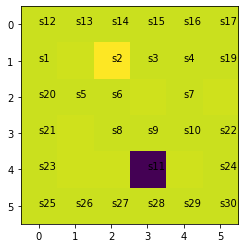

In [24]:
grid = GridWorld(p = 0.45)

The optimal value function and optimal policy caluclated using Dynamic Porgramming:

Epochs:  5


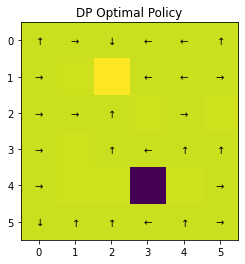

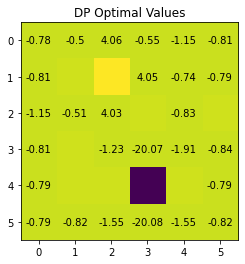

In [7]:
dp_policy, dp_values = grid.value_iteration(0.001, 0.2)
grid.draw_deterministic_policy(dp_policy, 'DP Optimal Policy')
grid.draw_value(dp_values, 'DP Optimal Values')

Assuming the dynamics of the model are unknown and the optimal policy is unknown, the optimal value function and optimal policy can be estimated using Monte Carlo reinforcement learning. The iterative monte carlo control algorithm is used to estimate the optimal policy. 

The starting state was randomly selected from the 27 valid, non-terminating states to ensure the estimation algorithm has sufficient knowledge of the gridworld environment (exploring starts). A decaying learning rate was used.  It was initialised to 1 and with each iteration it was multiplied by a decay factor (0.9995) until it reached a minimum of 0.05. This improved the outcome as Q(s,a) is updated by a large factor at the beginning and then as the estimation improves with each iteration the update factor is reduced so that it approaches the true optimal Q(s,a). A soft, epsilon-greedy policy was used to ensure the full state, action space was explored. Epsilon was initialized to 1 and then multiplied by a decaying factor (0.9994) for each iteration until it reached a set minimum value (0.05) so that the algorithm starts out using a uniform policy (100% random actions) and then explores less and exploits more as it learns more about the world but still continues to explore for all timesteps. Epsilon is therefore Greedy in the Limit with Infinite Exploration (GLIE), which guarantees that the monte carlo control algorithm converges to the optimal policy.


Episode 1000 -> epsilon=0.54871281936461
Episode 2000 -> epsilon=0.30108575813505833
Episode 3000 -> epsilon=0.16520961521681843
Episode 4000 -> epsilon=0.09065263375176265
Episode 5000 -> epsilon=0.05
Episode 6000 -> epsilon=0.05
Episode 7000 -> epsilon=0.05
Episode 8000 -> epsilon=0.05


Text(0.5, 0, 'Iterations')

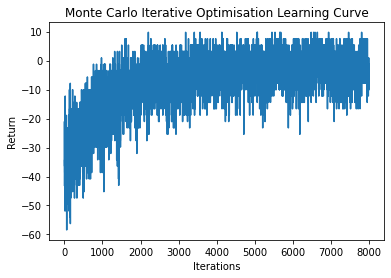

In [10]:
mc_policy, rmse, return_progress = grid.mc_iterative(8000, dp_policy, gamma = 0.2)

plt.plot(return_progress)
plt.title('Monte Carlo Iterative Optimisation Learning Curve')
plt.ylabel('Return')
plt.xlabel('Iterations')


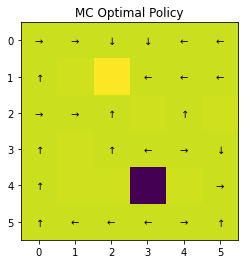

In [11]:
grid.draw_deterministic_policy(mc_policy, 'MC Optimal Policy')

The optimal value function can be estimated using first visit incremental monte carlo estimation. The value for a state is estimated as the mean return for that state which converges to the optimal value for a policy if an infinite number of episodes is observed.

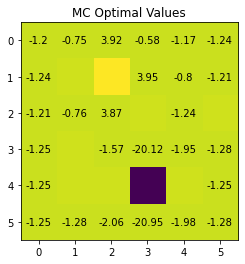

In [20]:
mc_values, mc_rmse = grid.mc_estimation(mc_policy, dp_values, 40000)
grid.draw_value(mc_values, 'MC Optimal Values')

Text(0.5, 0, 'Episodes')

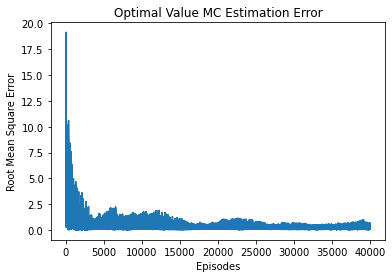

In [21]:
plt.plot(mc_rmse)
plt.title('Optimal Value MC Estimation Error')
plt.ylabel('Root Mean Square Error')
plt.xlabel('Episodes')

The SARSA TD control algorithm can also be used to caluclated the optimal policy when the dynamics of the model are unknown.

Episode 1000 -> epsilon=0.54871281936461
Episode 2000 -> epsilon=0.30108575813505833
Episode 3000 -> epsilon=0.16520961521681843
Episode 4000 -> epsilon=0.09065263375176265
Episode 5000 -> epsilon=0.05
Episode 6000 -> epsilon=0.05
Episode 7000 -> epsilon=0.05
Episode 8000 -> epsilon=0.05
Episode 9000 -> epsilon=0.05
Episode 10000 -> epsilon=0.05


Text(0.5, 0, 'Iterations')

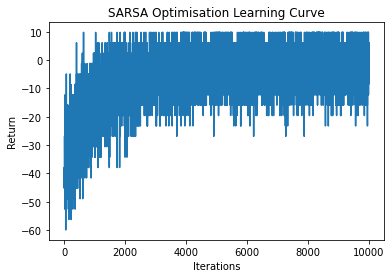

In [22]:
td_policy, return_progress = grid.sarsa(10000, dp_values)

plt.plot(return_progress)
plt.title('SARSA Optimisation Learning Curve')
plt.ylabel('Return')
plt.xlabel('Iterations')

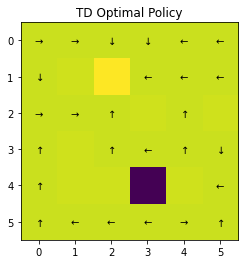

In [26]:
grid.draw_deterministic_policy(td_policy, 'TD Optimal Policy')

This policy is then fed to the temporal difference value function estimation algorithm to estimate the optimal value function for this policy. A greedy soft policy (GLIE) was implemented and the epsilon valuewas decayed with each episode.The learning rate was also decayed. 

ep: 0
ep: 20000


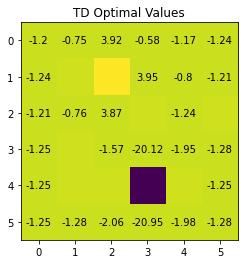

In [25]:
td_values, td_rmse = grid.td_estimation(td_policy, dp_values, 40000)
grid.draw_value(mc_values, 'TD Optimal Values')

Text(0.5, 0, 'Episodes')

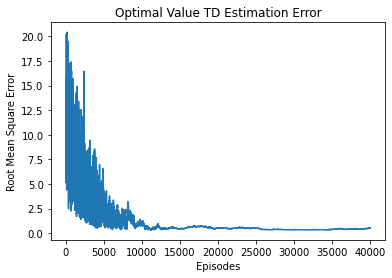

In [27]:
plt.plot(td_rmse)
plt.title('Optimal Value TD Estimation Error')
plt.ylabel('Root Mean Square Error')
plt.xlabel('Episodes')